<div style="text-align: center;"> 
    <span style="font-size: 40px; font-weight: bold">
        Lập trình cho Khoa học dữ liệu - CQ2023/21
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 24px; font-weight: bold">
        <i>
            02. Preprocessing
        </i>
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 18px">
            Nguyễn Lê Tấn Phát - 22120262
    </span>
</div>

<div style="text-align: right;">
    <span style="font-size: 14px">
        <i>
            Nov 23, 2025
        </i>
    </span>
</div>

---

<h1 align="center">
    <span style="font-size: 40px; font-weight: bold">
        Mục lục
    </span style>
</h1>

- [**I. Chuẩn bị thư viện**](#i)

- [**II. Chuẩn bị dữ liệu**](#ii)

- [**III. Tách dữ liệu**](#iii)

- [**IV. Undersampling**](#iv)

    - [**1. Triển khai Undersampling trên tập train**](#iv_1)

    - [**2. Lọc nhiễu sử dụng IQR**](#iv_2)

- [**V. SMOTE**](#v)

    - [**1. Triển khai SMOTE trên tập train**](#v_1)

    - [**2. Lọc nhiễu sử dụng IQR**](#v_2)

- [**VI. Lưu dữ liệu đã xử lí**](#vi)

- [**VII. Tham khảo**](#vii)
---

<h1 id="i" style="font-weight: bold">I. Chuẩn bị thư viện</h1>

In [2]:
import numpy as np
import os
import sys

sys.path.append(os.path.abspath('..'))
from src.data_processing import numpy_train_test_split, numpy_smote, remove_outliers_iqr, robust_scale_col
from src.visualization import plot_outlier_comparison, plot_dist_before_filter

---

<h1 id="ii" style="font-weight: bold">II. Chuẩn bị dữ liệu</h1>

In [3]:
print("--- 1. Loading Data ---")
def clean_class_col(x):
    return float(x.replace('"', ''))

raw_path = '../data/raw/creditcard.csv'
if not os.path.exists(raw_path):
    raise FileNotFoundError(f"Không tìm thấy file {raw_path}")

data_full = np.genfromtxt(raw_path, delimiter=',', skip_header=1, converters={30: clean_class_col})
X_raw = data_full[:, :-1]
y_raw = data_full[:, -1]
print(f"Shape gốc: {X_raw.shape}")

--- 1. Loading Data ---
Shape gốc: (284807, 30)


Scaling lại các giá trị của Time và Amount

In [4]:
X_scaled = X_raw.copy()
X_scaled[:, 0] = robust_scale_col(X_raw[:, 0])   # Time
X_scaled[:, -2] = robust_scale_col(X_raw[:, -2]) # Amount

Các đặc trưng có tương quan mạnh mà ta đã tìm thấy ở `01_data_exploration.ipynb`

In [5]:
features_to_plot = [14, 12, 11, 10, 4] 
feature_names = ['V14', 'V12', 'V11', 'V10', 'V4']

---

<h1 id="iii" style="font-weight: bold">III. Tách dữ liệu</h1>

Tách dữ liệu theo tỉ lệ 80/20. Ta tiến hành tách dữ liệu trước khi áp dụng các kĩ thuật SMOTE và Undersampling để đảm bảo ta không bị `Data Leakage` do dữ liệu giả được sinh ra lọt vào tập test.

In [6]:
X_train, X_test, y_train, y_test = numpy_train_test_split(X_scaled, y_raw, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape} | Fraud: {np.sum(y_train==1)}")
print(f"Test set:  {X_test.shape} | Fraud: {np.sum(y_test==1)}")

Train set: (227845, 30) | Fraud: 387
Test set:  (56962, 30) | Fraud: 105


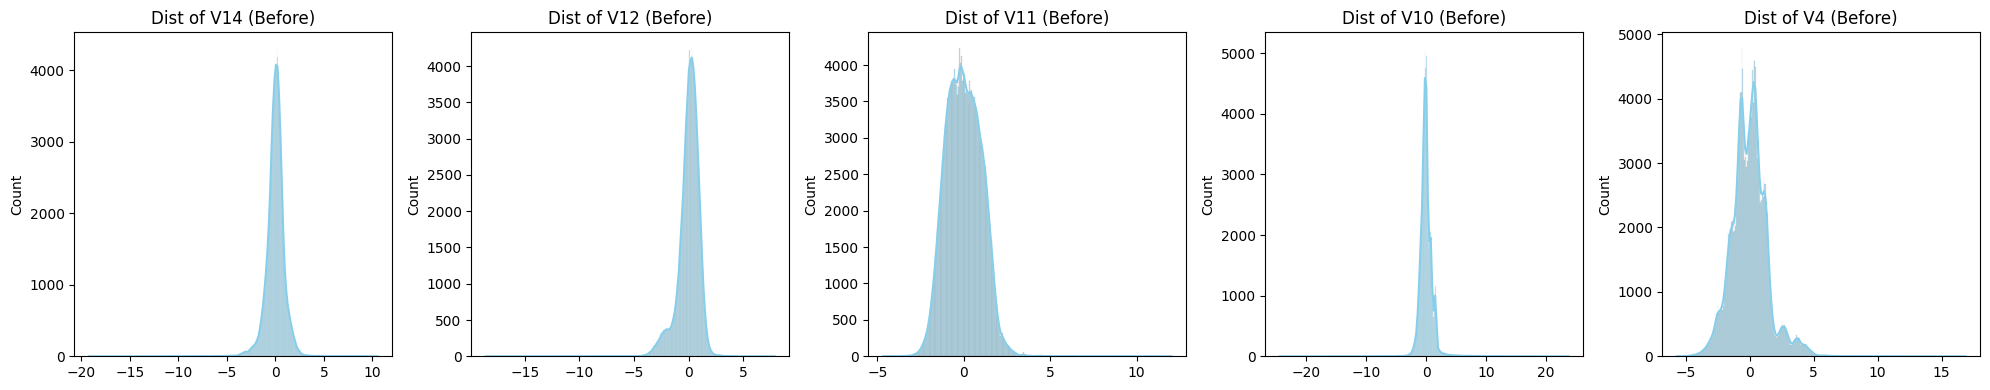

In [7]:
plot_dist_before_filter(X_train, features_to_plot, feature_names)

**V14**

- Phân phối rất lệch trái (left-skewed).

- Có một “đuôi dài” ở phía âm.

- Các giao dịch gian lận thường rơi vào vùng giá trị thấp bất thường.

**V12**

- Tương tự V14, tập trung cao quanh 0 nhưng có nhiều điểm outlier âm mạnh.

- Các giá trị âm sâu là dấu hiệu đặc trưng của fraud.

**V11**

- Phân phối khá đối xứng hơn V12 và V14 nhưng vẫn hơi lệch trái.

- Fraud tập trung ở vùng thấp hơn.

**V10**

- Có đuôi rất dài bên trái (âm cực mạnh).

- Đây là biến tương quan âm mạnh nhất với label trong bộ hình của bạn.

- Fraud thường xuất hiện khi V10 rất thấp, do vậy biến này cực kỳ quan trọng trong mô hình ML.

**V4**

- Phân phối hơi lệch phải (right-skewed).

- Có nhiều cụm (multi-modal), cho thấy biến này chứa nhiều pattern.

- Fraud có xu hướng xuất hiện khi V4 tăng, do tương quan dương.

---

<h1 id="iv" style="font-weight: bold">IV. Undersampling</h1>

<h2 id="iv_1" style="font-weight: bold">1. Triển khai Undersampling trên tập train</h2>

In [8]:
# Thực hiện undersampling trên tập TRAIN
fraud_idx = np.where(y_train == 1)[0]
normal_idx = np.where(y_train == 0)[0]
normal_idx_under = np.random.choice(normal_idx, size=len(fraud_idx), replace=False)
under_idx = np.concatenate([fraud_idx, normal_idx_under])
np.random.shuffle(under_idx)

X_train_under = X_train[under_idx]
y_train_under = y_train[under_idx]

<h2 id="iv_2" style="font-weight: bold">2. Lọc nhiễu sử dụng IQR</h2>

In [9]:
print("Lọc nhiễu tập Undersampled...")
X_train_under_clean, y_train_under_clean = remove_outliers_iqr(X_train_under, y_train_under, features_to_plot, threshold=1.5)
print(f"Shape sau xử lý: {X_train_under_clean.shape}")

Lọc nhiễu tập Undersampled...
  - Số lượng mẫu trước khi lọc: 774
  - Số lượng mẫu sau khi lọc: 704
  - Đã loại bỏ: 70 mẫu nhiễu.
Shape sau xử lý: (704, 30)


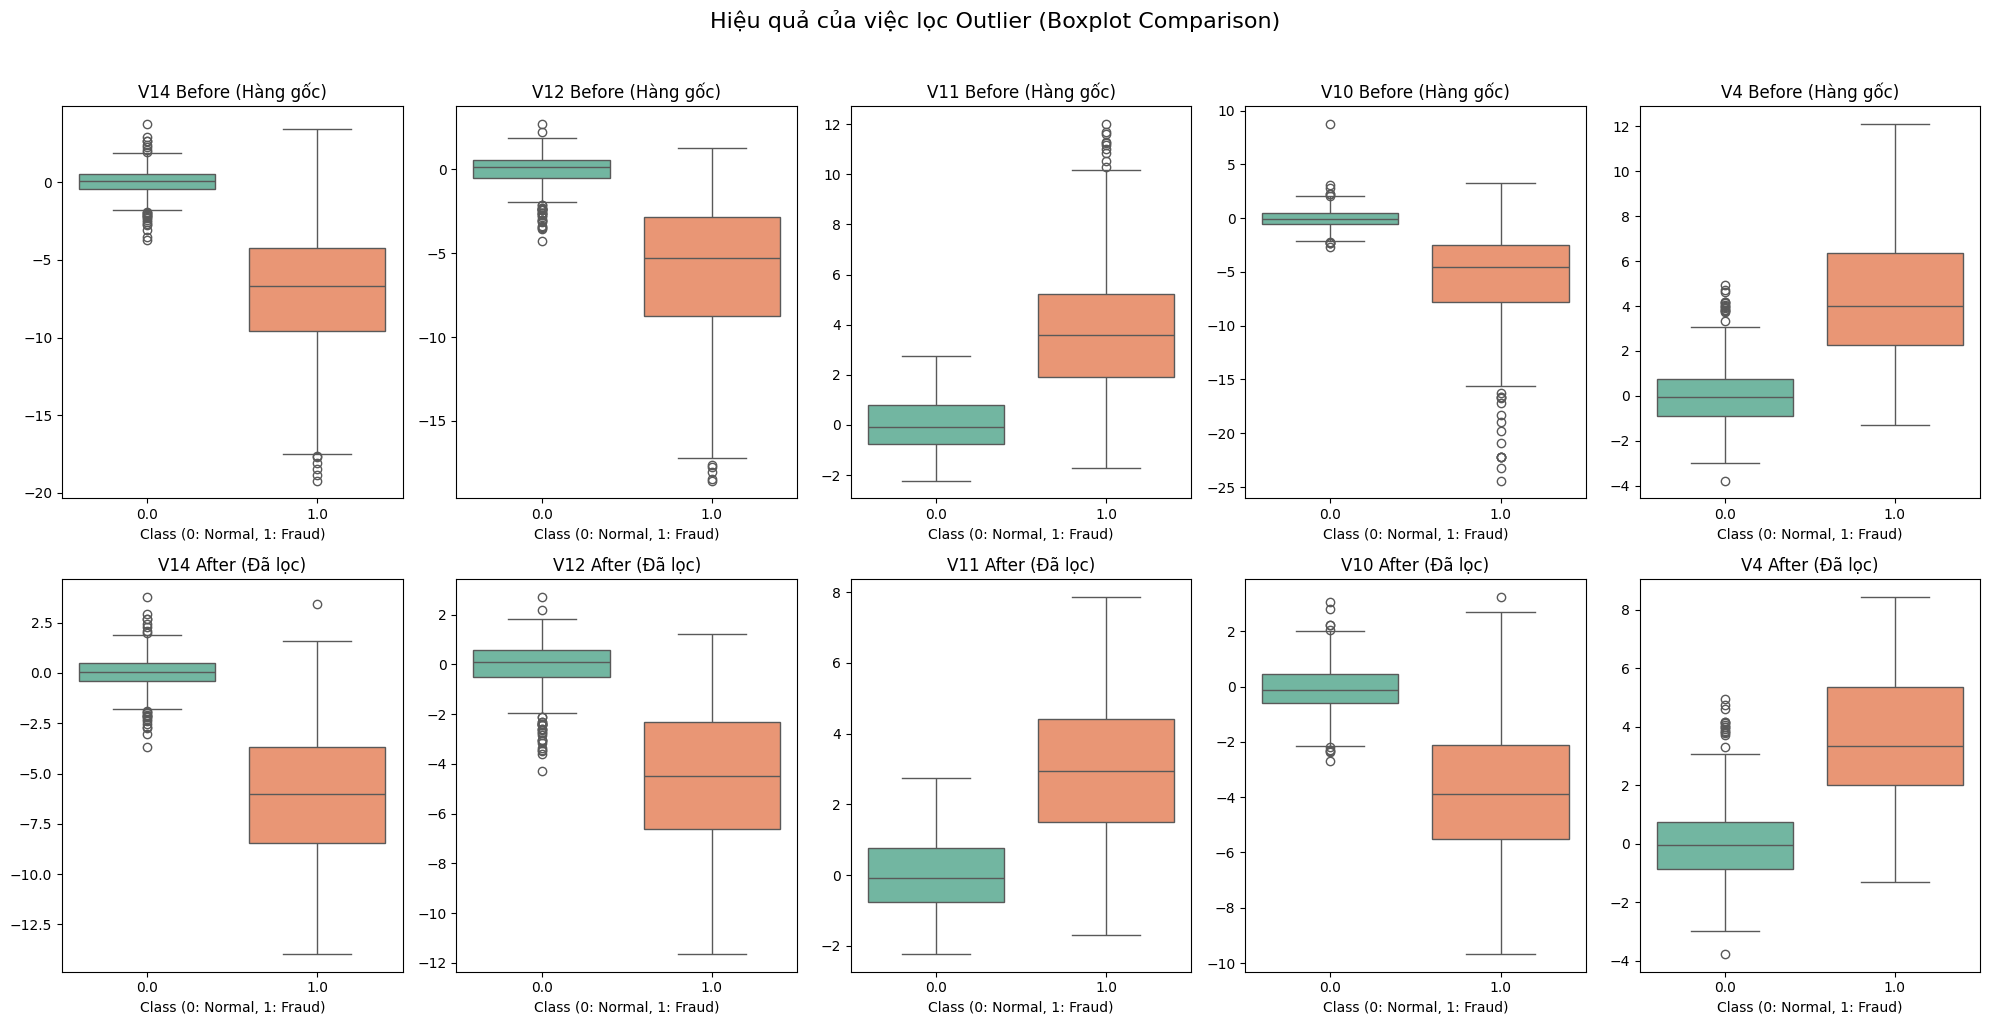

In [10]:
plot_outlier_comparison(
    X_train_under, y_train_under,               # Trước khi lọc
    X_train_under_clean, y_train_under_clean,   # Sau khi lọc
    features_to_plot, feature_names
)

**V14**

Before:

- Giao dịch Bình thường hơi lệch trái.

- Giao dịch Gian lận trải dài rất rộng, có nhiều nhiễu ở cả hai phía.

- Chồng chéo khá nhiều giữa hai class $\rightarrow$, nhiễu cao.

After:

- Phạm vi của cả hai class thu hẹp lại rõ rệt.

- Đuôi nhiễu dài đã biến mất.

- Hai class phân tách tốt hơn, giao dịch Gian lận có median thấp hơn rõ ràng.

$\rightarrow$ IQR hoạt động tốt trên V14, làm phân phối sắc nét hơn và sạch nhiễu.

**V12**

Before

- Giao dịch gian lận có rất nhiều điểm cực trị (≈ -15 đến -20), biểu hiện nhiễu rõ rệt.

- Giao dịch bình thường tương đối tập trung quanh 0 nhưng vẫn có vài nhiễu.

After

- Nhiễu hầu như biến mất.

- Giao dịch Bình thường và Gian lận tách nhau rõ hơn (Giao dịch Gian lận lệch trái hơn giao dịch Bình thường).

- Median ổn định hơn nhiều.

$\rightarrow$ V12 được cải thiện mạnh sau khi lọc IQR.

**V11**

Before

- Phân phối khá chuẩn Gaussian, nhưng giao dịch Gian lận có đuôi dài và trải rộng hơn giao dịch Bình thường.

- Chưa có quá nhiều nhiễu, nhưng vẫn có một vài điểm cực trị.

After

- Phạm vi giao dịch Gian lận thu hẹp xuống, median rõ nét hơn.

- Cấu trúc Gaussian vẫn giữ nguyên.

- Ít nhiễu, hai class rõ ràng hơn so với trước.

$\rightarrow$ V11 vốn đã sạch nhưng IQR vẫn giúp làm ổn định tập giao dịch Gian lận.

**V10**

Before

- Là đặc trưng có nhiễu lớn nhất.

- Giao dịch Gian lận có rất nhiều nhiễu ở cả hướng âm & dương.

- Giao dịch Bình thường có phân phối chặt chẽ hơn nhưng vẫn bị ảnh hưởng bởi nhiễu.

After

- Phân phối giao dịch Gian lận thu hẹp mạnh.

- Giao dịch Bình thường gần như không có outlier nữa.

- Khoảng cách giữa giao dịch Gian lận và giao dịch Bình thường rõ ràng và nhiều hơn Before.

$\rightarrow$ V10 được cải thiện rõ rệt nhờ IQR.

**V4**

Before

- Cả hai class đều bị nhiễu kéo đuôi dài.

- Giao dịch Gian lận trải dài nhất, làm phân phối rất rộng.

After

- Nhiễu được cắt bỏ, phạm vi nhỏ gọn hơn.

- Giao dịch Gian lận và giao dịch Bình thường tách nhau tốt hơn (giao dịch Gian lận lệch phải hơn giao dịch Bình thường).

$\rightarrow$ Cải thiện rất tốt

---

<h1 id="v" style="font-weight: bold">V. SMOTE</h1>

<h2 id="v_1" style="font-weight: bold">1. Triển khai SMOTE trên tập train</h2>

In [11]:
print("\n--- 5. Case 2: SMOTE ---")
# Thực hiện SMOTE trên tập TRAIN gốc
X_train_smote, y_train_smote = numpy_smote(X_train, y_train, k_neighbors=5)


--- 5. Case 2: SMOTE ---
  - Bắt đầu sinh 227071 mẫu SMOTE từ 387 mẫu gốc...


<h2 id="v_2" style="font-weight: bold">2. Lọc nhiễu sử dụng IQR</h2>

In [12]:
print("Lọc nhiễu tập SMOTE...")
X_train_smote_clean, y_train_smote_clean = remove_outliers_iqr(X_train_smote, y_train_smote, features_to_plot, threshold=2.5)
print(f"Shape sau xử lý: {X_train_smote_clean.shape}")

Lọc nhiễu tập SMOTE...
  - Số lượng mẫu trước khi lọc: 454916
  - Số lượng mẫu sau khi lọc: 445404
  - Đã loại bỏ: 9512 mẫu nhiễu.
Shape sau xử lý: (445404, 30)


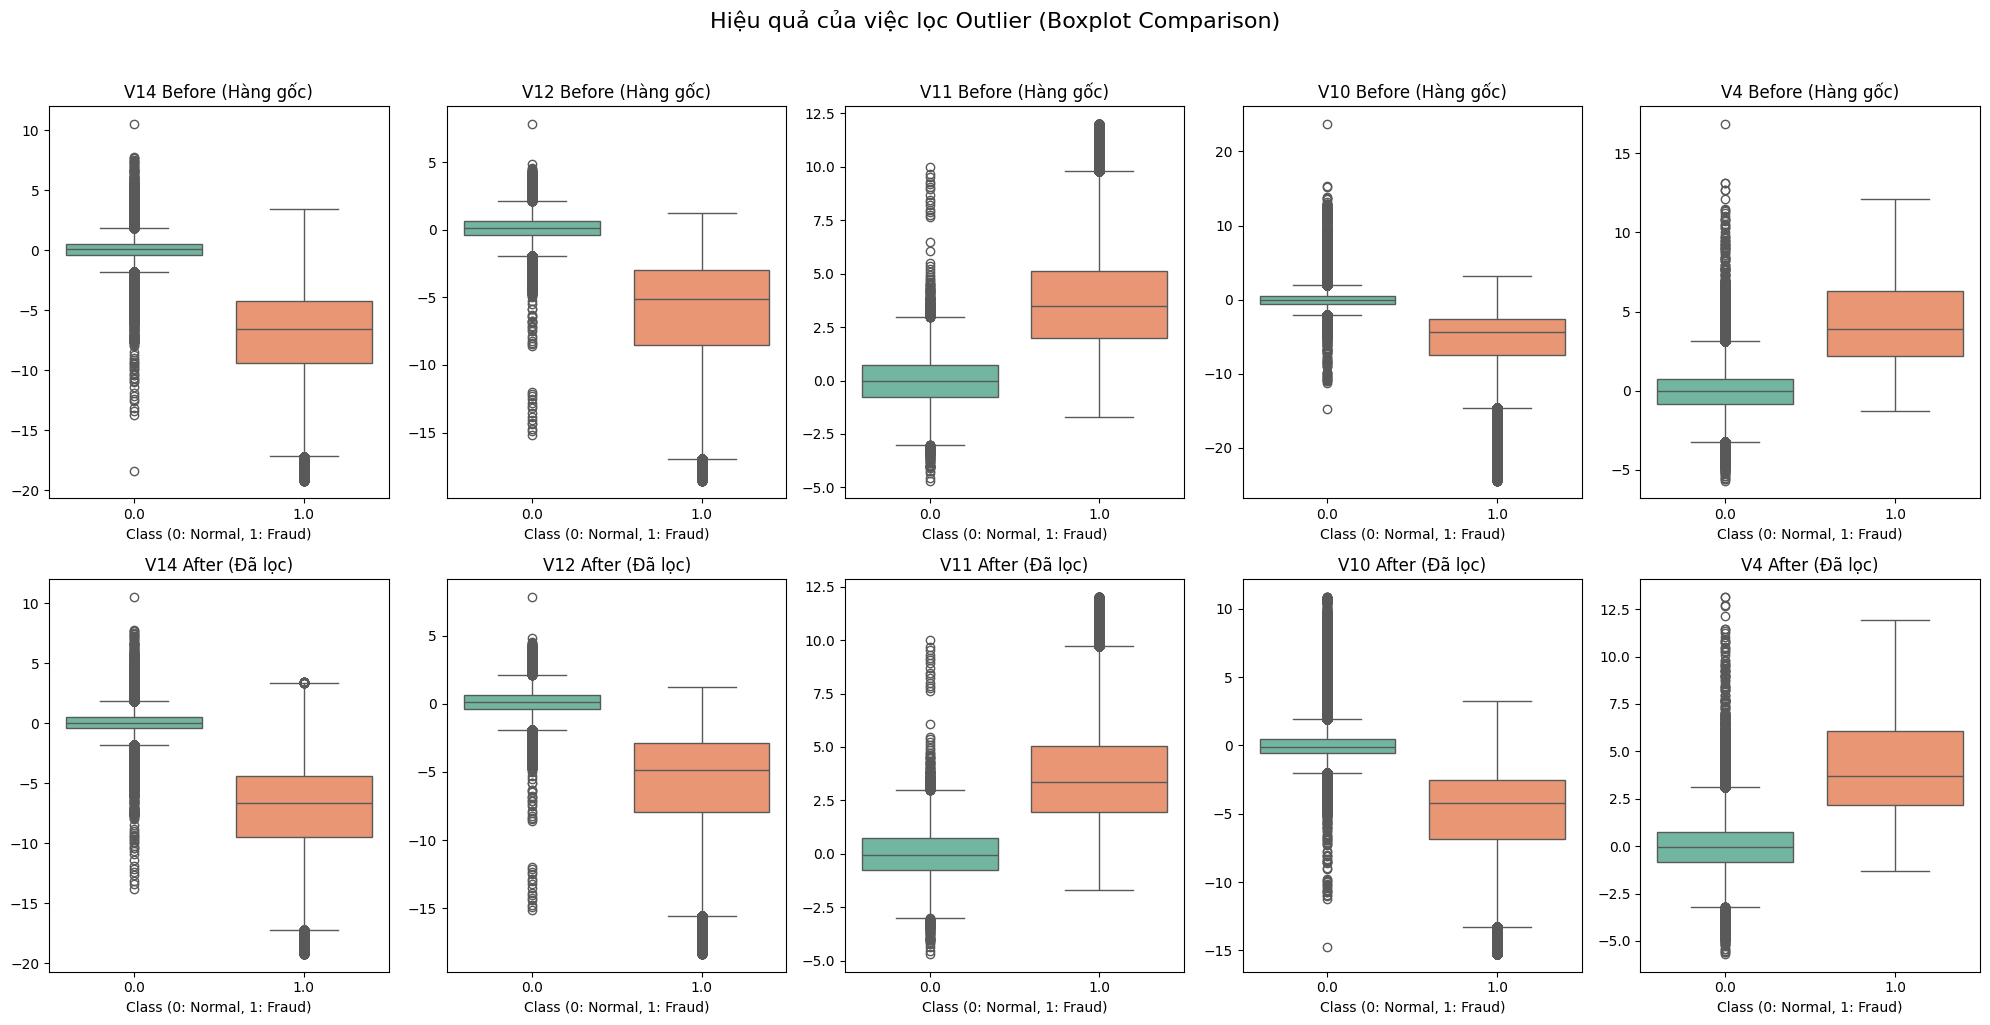

In [13]:
plot_outlier_comparison(
    X_train_smote, y_train_smote,               # Trước khi lọc
    X_train_smote_clean, y_train_smote_clean,   # Sau khi lọc
    features_to_plot, feature_names
)

---

<h1 id="vi" style="font-weight: bold">VI. Lưu dữ liệu đã xử lí</h1>

In [14]:
processed_dir = '../data/processed'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Lưu tập Test (Dùng chung cho cả 2 case để so sánh công bằng)
np.savez(os.path.join(processed_dir, 'test_data.npz'), X=X_test, y=y_test)

# Lưu tập Train Undersampled
np.savez(os.path.join(processed_dir, 'train_under.npz'), X=X_train_under, y=y_train_under)

# Lưu tập Train SMOTE
np.savez(os.path.join(processed_dir, 'train_smote.npz'), X=X_train_smote, y=y_train_smote)

print(f"Đã lưu 3 file dữ liệu (.npz) vào thư mục {processed_dir}")

Đã lưu 3 file dữ liệu (.npz) vào thư mục ../data/processed


---

<h1 id="vii" style="font-weight: bold">VII. Tham khảo</h1>

[Credit Fraud || Dealing with Imbalanced Datasets - Janio Martinez Bachmann](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)